<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/problem_sets/solutions/Problem_Set_Six_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [138]:
#@title Imports { display-mode: "form" }
%%capture 
!pip install jaxopt
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import matplotlib.pyplot as plt 
from functools import partial 
import matplotlib as mpl
from matplotlib import rcParams
from mpl_toolkits import mplot3d
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

We assume that workers differ in some way which we denote by $t$. We represent this mathematically by saying that the type of the work (t) follows a uniform distribution **parameterized** by $(m,c)$ as follows:

$$t \sim U(m - 3c, m + 3c)$$

We construct a function that allows us to sample from this distribution below.

In [139]:
def sample_worker_type(m, c, key): 
  return jax.random.uniform(key, minval=m-c*3, maxval=m+c*3)

Let's partially evalute the above function at $m=5$ and $c=2$ and refer to this function as $f$. By doing so, we can sample multiple individuals from the same distribution by:


1.   Vectorizing the function $f$
2.   Pass in a vector of keys



In [140]:
f = partial(sample_worker_type, .5, .1)                                         # Partially Evaluate Function 
vector_of_keys = jax.random.split(jax.random.PRNGKey(0), 2000)                  # Splitting creates a new vector of keys based on an original key
vectorized_f = jax.vmap(f)
samples = vectorized_f(vector_of_keys)

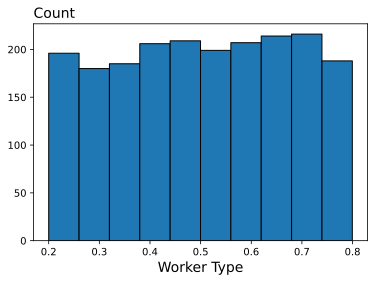

In [141]:
#@title Samples of Workers' Types { display-mode: "form" }
plt.hist(samples, edgecolor='black')
plt.xlabel('Worker Type', size=14)
plt.title('Count', size=14, loc='left') 
plt.show()

Acquiring a license is costly. Importantly, we allow this cost to depend on the type of individual. As we show below, the cost is a decreasing functioin of the type of the individual.

\begin{align*}
\textrm{Cost_of_license}(t) = c_0  + c_1t
\end{align*}

In [142]:
#@title Cost of License { display-mode: "form" }
def cost_license(c0, c1, t):
  """ 
  - c0, c1 parameterize the cost function of a getting a license
  - t denotes the worker's type
  """
  return c0 + c1*t**.4

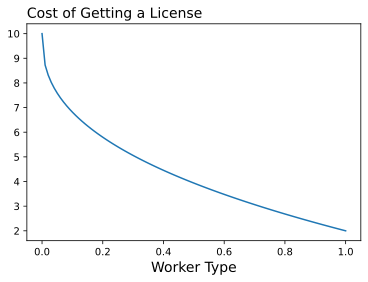

In [143]:
#@title Cost of License { display-mode: "form" }
c0, c1 = 10., -8. 
ws = jnp.linspace(0, 1, 100)
ys = jax.vmap(partial(cost_license, c0, c1))(ws)
plt.plot(ws, ys, label=i)
plt.title('Cost of Getting a License', loc='left', size=14)
plt.xlabel('Worker Type',size=14)
plt.show()

Let's assume that a firm only observes wether or not an individual has a license. Then the wage offered by the firm can be expressed as follows:

\begin{align*}
\textrm{wage}(\textrm{license}) = \begin{cases} w_0 \quad \textrm{if} \ \textrm{license} = 0 \\ 
w_1 \quad \textrm{if} \ \textrm{license} = 1\end{cases}
\end{align*}

**Note**: The domain for the wage function is a finite set (there are only two elments in it $\{0, 1\}$), therefore we can represent this function as a vector where $w[0]$ can be thought of as evaluating the wage function at $0$. 

### **Question 1**:
Write down the optimal action of the worker as a function of the parameters of the cost of license function, the wage vector and worker type


In [144]:
def optimal_action_worker(c0, c1, w, t):
  cost_of_license =  cost_license(c0, c1, t)
  monetary_gain_from_license = w[1] - cost_of_license
  monetary_gain_from_no_license = w[0]
  condition = monetary_gain_from_license > monetary_gain_from_no_license
  return jnp.where(condition, 1., 0. )

### **Question 2**:

Play around with the parameters of the the cost and wage functions to get some intuition for how the influence the optimal action



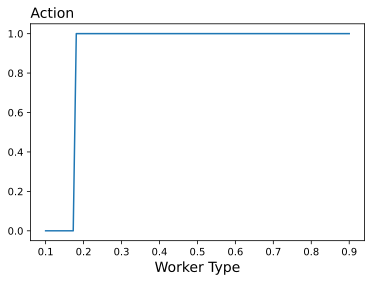

In [145]:
#@title Graph of Optimal Action { display-mode: "form" }
w = jnp.array([6., 12])    # Wage function

# Vectorized Action Function
action_fn = partial(optimal_action_worker, c0, c1, w)

# Vector of Worker Types
ts = jnp.linspace(0.1, 0.9, 100)

# Corresponding Action for Each Worker Type 
actions = jax.vmap(action_fn)(ts)

# Graph
plt.plot(ts, actions)
plt.title('Action', size=14, loc='left')
plt.xlabel('Worker Type', size=14)
plt.show()

#**The Firm Problem**
We begin by writing identifying the choice set of the firm and the objective function. 
\begin{align*}
\underset{\textrm{wage_fn}}{\textrm{maximize}} \ &\mathbb{E}\big[\textrm{Profit}(\textrm{wage_fn})\big] 
\end{align*}

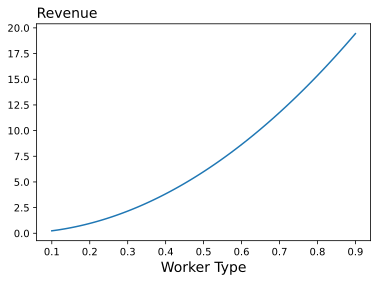

In [146]:
def g(t):
  """Productivity Function"""
  return 8.*t**2 

price_per_unit = 3. 

ts = jnp.linspace(0.1, .9, 100)
revenues = jax.vmap(g)(ts)*price_per_unit 
plt.plot(ts, revenues)
plt.title('Revenue', loc='left', size=14)
plt.xlabel('Worker Type', size=14)
plt.show()

In [172]:
# Outside Wage Function
outside_wage = jnp.array([-.1, -.1])

In [173]:
def profit_per_type(optimal_action_worker_fn, wage_fn, t):
  license = optimal_action_worker_fn(wage_fn, t).astype(jnp.int32)
  output = g(t)
  revenue = price_per_unit * output
  cost = wage_fn[license]
  profit = revenue-cost 
  work_status = cost > outside_wage[license]
  return profit*work_status, license, work_status

In [174]:
def expected_profit(optimal_action_worker_fn, wage_fn):
  ts = jnp.linspace(0.1, 0.9, 1000) 
  profits, _, _ = jax.vmap(partial(profit_per_type, optimal_action_worker_fn, wage_fn))(ts)
  return jnp.mean(profits)

In [175]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_non_negative

def optimal_wage():
  
  def closure(wage_fn):
    ts = jnp.linspace(0.1, 0.9, 100)
    f = lambda t: profit_per_type(oaw, wage_fn, t)[0] # We want the profit not the license 
    profits = jax.vmap(f)(ts)
    return -1.*jnp.mean(profits) 
  solver = ProjectedGradient(fun=closure, projection=projection_non_negative, maxiter=2000)
  res = solver.run(jnp.array([7., 12.]))
  return res.params

In [176]:
oaw = partial(optimal_action_worker, c0, c1)
opt_wage = optimal_wage()
print(opt_wage)

[0. 0.]


In [177]:
expected_profit(oaw, opt_wage)

DeviceArray(7.28256256, dtype=float64)

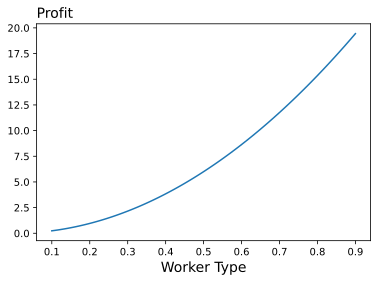

In [178]:
temp_profit_type = partial(profit_per_type, oaw, opt_wage)
ts = jnp.linspace(0.1, 0.9, 100)
ppt, licenses, work_status = jax.vmap(temp_profit_type)(ts)
plt.title('Profit', loc='left', size=14)
plt.xlabel('Worker Type', size=14)
plt.plot(ts, ppt)
plt.show()

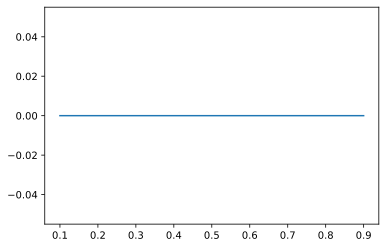

In [179]:
plt.plot(ts, licenses)
plt.show()

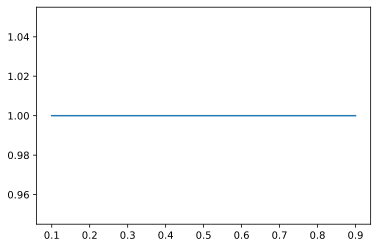

In [180]:
plt.plot(ts, work_status)
plt.show()